Install mlfow library

In [2]:
!pip install xgboost shap mlflow joblib -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

Import Libraries

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import mlflow
import mlflow.xgboost
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score


 Load the dataset and Perform Data Cleaning

In [6]:
df = pd.read_csv("car_insurance_claim.csv")
df.drop(['ID', 'BIRTH'], axis=1, inplace=True)
money_cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
for col in money_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).replace('', np.nan).astype(float)


Handling the missing values

In [7]:
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

<ipython-input-7-01bd41237e44>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Encode Categorical Columns

In [17]:
cat_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Prepare the Features and Labels with scaling

In [18]:
scaler = StandardScaler()
X = df.drop('CLAIM_FLAG', axis=1)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = df['CLAIM_FLAG']


Setup MLflow & Stratified K-Fold Training

In [19]:
mlflow.set_experiment("Car_Insurance_XGBoost")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': (y == 0).sum() / (y == 1).sum(),
    'eta': 0.1,
    'max_depth': 6,
    'seed': 42
}
auc_scores = []
fold = 0

Train XGBoost with Cross-Validation with MLflow Logging

In [22]:
mlflow.end_run()
# Note*: mlflow instance acan be running only once and make sure you end the mlflow instance by executing the above line of code

In [23]:
for train_idx, val_idx in skf.split(X_scaled, y):
    fold += 1
    X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    with mlflow.start_run(run_name=f"fold_{fold}"):
        model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=20,
                          evals=[(dval, 'eval')], verbose_eval=False)
        preds = model.predict(dval)
        auc = roc_auc_score(y_val, preds)
        auc_scores.append(auc)
        mlflow.log_params(params)
        mlflow.log_metric("AUC", auc)
        mlflow.xgboost.log_model(model, artifact_path="model")
print(f"Average AUC over 5 folds: {np.mean(auc_scores):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:17:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/17 15:17:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:17:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/17 15:17:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib

Average AUC over 5 folds: 0.9988


In [28]:
mlflow.end_run()

Train the Final Model on the full dataset

In [24]:
dall = xgb.DMatrix(X_scaled, label=y)
final_model = xgb.train(params, dall, num_boost_round=int(model.best_iteration * 1.1))
with mlflow.start_run(run_name="final_model"):
    mlflow.xgboost.log_model(final_model, artifact_path="final_model")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:18:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/17 15:18:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Explainability with SHAP (Feature Importance Visualization)

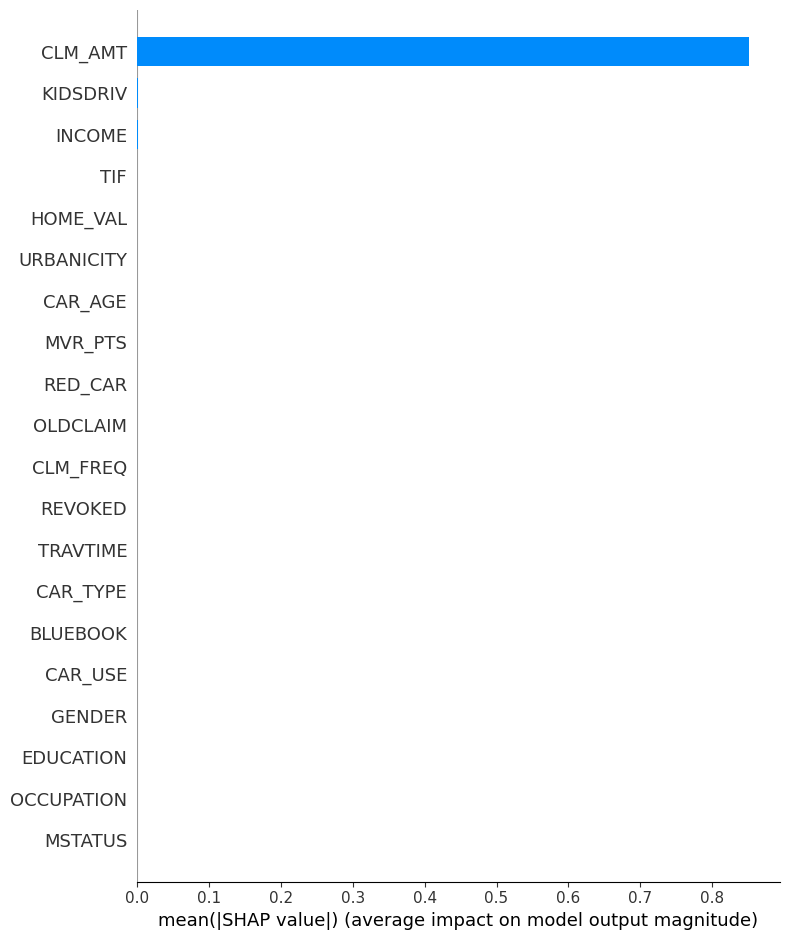

In [25]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, plot_type="bar")


In [26]:
auc = roc_auc_score(y_val, preds)
auc_scores.append(auc)
mlflow.log_metric("AUC", auc)
print(f"Average AUC over 5 folds: {np.mean(auc_scores):.4f}")


Average AUC over 5 folds: 0.9986


Save the model , StandardScaler object , LabelEncoder objects

In [27]:
joblib.dump(final_model, 'final_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')


['label_encoders.pkl']